In [1]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960


# Import important libraries

In [2]:
import numpy as np
import tensorflow as tf
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import LSTM,Conv1D,Conv2D,MaxPooling2D,MaxPooling1D,Flatten
from keras.layers import Dense, Dropout
import pandas as pd
# from keras.optimizers import Adam
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import seaborn as sns
#from datetime import datetime

from tensorflow.compat.v1.keras.layers import CuDNNLSTM,Bidirectional
seed=42

# Load the dataset

In [3]:
#Read the csv file
df = pd.read_csv('/content/Final_nflx_data_2018-2022 (2).csv')
df['date'] = pd.to_datetime(df['date'])
df

,date,Open,High,Low,Close,Adj Close,Volume,P_mean,P_sum,twt_count
0,2018-01-02,196.100006,201.649994,195.419998,201.070007,201.070007,10966900,0.020833,10,480
1,2018-01-03,202.050003,206.210007,201.500000,205.050003,205.050003,8591400,0.071217,24,337
2,2018-01-04,206.199997,207.050003,204.000000,205.630005,205.630005,6029600,-0.018519,-4,216
3,2018-01-05,207.250000,210.020004,205.589996,209.990005,209.990005,7033200,-0.019737,-6,304
4,2018-01-08,210.020004,212.500000,208.440002,212.050003,212.050003,5580200,-0.007663,-2,261
...,...,...,...,...,...,...,...,...,...,...
1132,2022-07-01,176.490005,180.100006,174.270004,179.949997,179.949997,5194700,-0.062315,-21,337
1133,2022-07-05,176.279999,185.919998,172.679993,185.880005,185.880005,7334300,-0.058824,-25,425
1134,2022-07-06,185.199997,186.220001,180.820007,184.059998,184.059998,5753400,-0.014870,-8,538
1135,2022-07-07,184.270004,190.210007,183.500000,189.270004,189.270004,6334500,-0.055427,-24,433


## Understanding the time Series

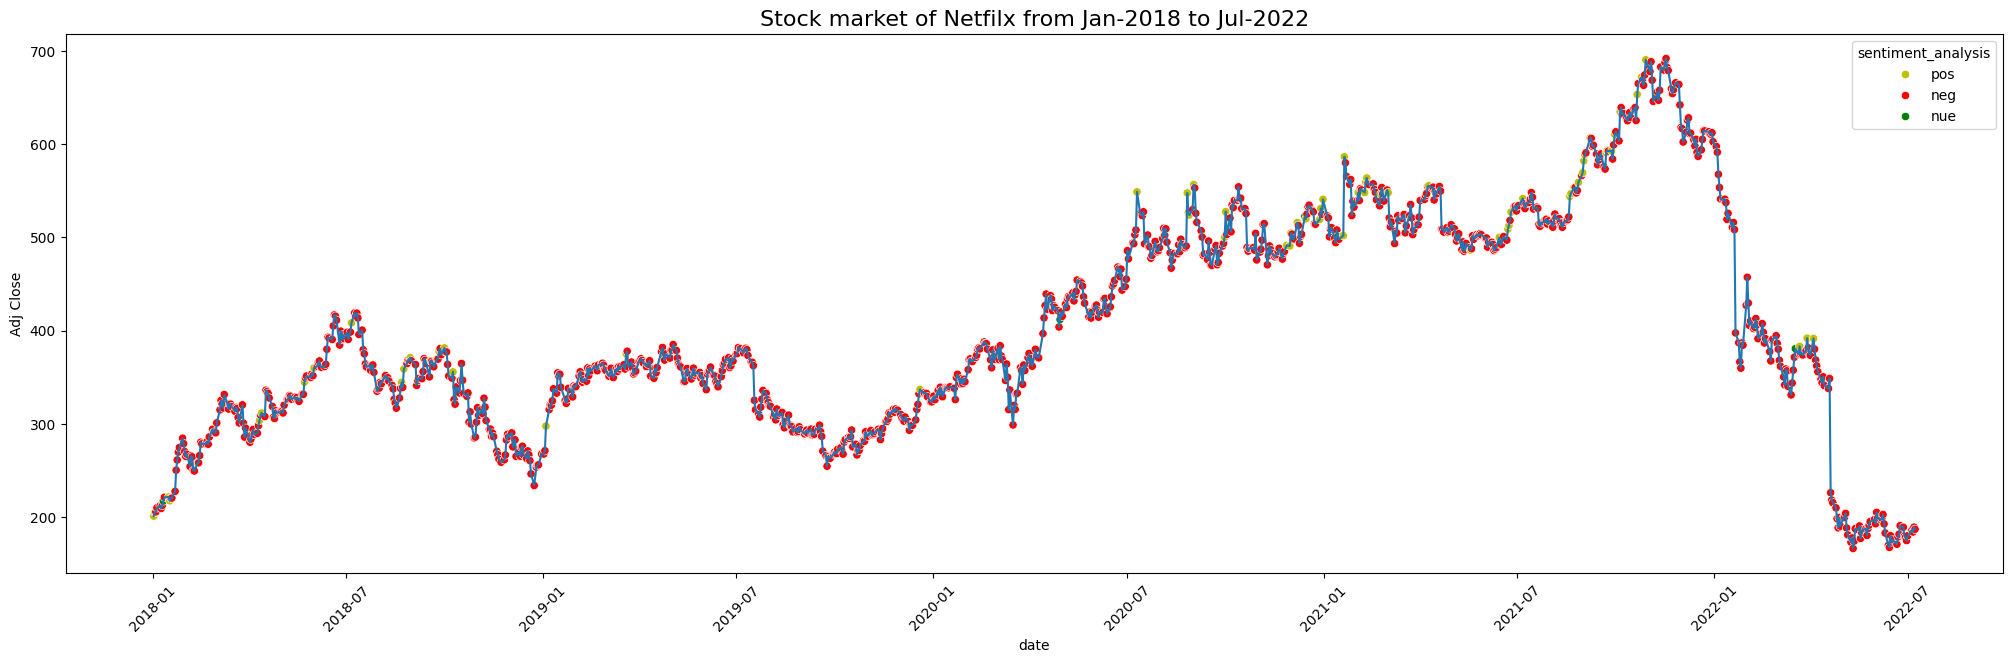

In [4]:
import seaborn as sns
plt.figure(figsize=(25,7));
sns.lineplot(x=df["date"],y=df["Adj Close"])
df['sentiment_analysis']=df['P_mean']
df['sentiment_analysis']=df['sentiment_analysis'].apply(lambda x: 'pos' if x>0 else 'nue' if x==0 else 'neg')
sns.scatterplot(x=df["date"],y=df['Adj Close'],hue=df['sentiment_analysis'],palette=['y','r','g'])
plt.xticks(rotation=45);
plt.title("Stock market of Netfilx from Jan-2018 to Jul-2022",fontsize=16);

In [5]:
df['sentiment_analysis'].value_counts()

neg    1059
pos      71
nue       7
Name: sentiment_analysis, dtype: int64

In [6]:
df=df.drop(list(range(14)),axis=0,inplace=False)
df

,date,Open,High,Low,Close,Adj Close,Volume,P_mean,P_sum,twt_count,sentiment_analysis
14,2018-01-23,255.050003,257.709991,248.020004,250.289993,250.289993,27705300,-0.061196,-88,1438,neg
15,2018-01-24,250.880005,261.709991,249.309998,261.299988,261.299988,17352400,-0.084525,-65,769,neg
16,2018-01-25,263.000000,272.299988,260.230011,269.700012,269.700012,15336400,-0.122744,-102,831,neg
17,2018-01-26,271.489990,274.600006,268.760010,274.600006,274.600006,11021800,-0.118012,-57,483,neg
18,2018-01-29,274.200012,286.809998,273.920013,284.589996,284.589996,17529700,-0.100690,-73,725,neg
...,...,...,...,...,...,...,...,...,...,...,...
1132,2022-07-01,176.490005,180.100006,174.270004,179.949997,179.949997,5194700,-0.062315,-21,337,neg
1133,2022-07-05,176.279999,185.919998,172.679993,185.880005,185.880005,7334300,-0.058824,-25,425,neg
1134,2022-07-06,185.199997,186.220001,180.820007,184.059998,184.059998,5753400,-0.014870,-8,538,neg
1135,2022-07-07,184.270004,190.210007,183.500000,189.270004,189.270004,6334500,-0.055427,-24,433,neg


from matplotlib import pyplot as plt
df['Open'].plot(kind='hist', bins=20, title='Open')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df['High'].plot(kind='hist', bins=20, title='High')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df['Low'].plot(kind='hist', bins=20, title='Low')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df['Close'].plot(kind='hist', bins=20, title='Close')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('sentiment_analysis').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='Open', y='High', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='High', y='Low', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='Low', y='Close', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='Close', y='Adj Close', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['date']
  ys = series['Open']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('date', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('sentiment_analysis')):
  _plot_series(series, series_name, i)
  fig.legend(title='sentiment_analysis', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('Open')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['date']
  ys = series['High']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('date', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('sentiment_analysis')):
  _plot_series(series, series_name, i)
  fig.legend(title='sentiment_analysis', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('High')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['date']
  ys = series['Low']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('date', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('sentiment_analysis')):
  _plot_series(series, series_name, i)
  fig.legend(title='sentiment_analysis', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('Low')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['date']
  ys = series['Close']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('date', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('sentiment_analysis')):
  _plot_series(series, series_name, i)
  fig.legend(title='sentiment_analysis', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('Close')

from matplotlib import pyplot as plt
df['Open'].plot(kind='line', figsize=(8, 4), title='Open')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df['High'].plot(kind='line', figsize=(8, 4), title='High')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df['Low'].plot(kind='line', figsize=(8, 4), title='Low')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df['Close'].plot(kind='line', figsize=(8, 4), title='Close')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df['sentiment_analysis'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df, x='Open', y='sentiment_analysis', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df['sentiment_analysis'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df, x='High', y='sentiment_analysis', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df['sentiment_analysis'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df, x='Low', y='sentiment_analysis', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df['sentiment_analysis'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df, x='Close', y='sentiment_analysis', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [7]:
train_dates = pd.to_datetime(df['date'])
# print(train_dates.tail(15)) #Check last few dates.

#Variables for training
cols = [
    'Open',
    'High', 'Low',
    'Close',
    'Volume',
    'Adj Close',
    'P_mean',
        ]
#Date and volume columns are not used in training.
print(cols)

#New dataframe with only training data - 5 columns
df_for_training = df[cols].astype(float)
df_for_training.index=df['date']
df_for_training

['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close', 'P_mean']


,Open,High,Low,Close,Volume,Adj Close,P_mean
date,,,,,,,
2018-01-23,255.050003,257.709991,248.020004,250.289993,27705300.0,250.289993,-0.061196
2018-01-24,250.880005,261.709991,249.309998,261.299988,17352400.0,261.299988,-0.084525
2018-01-25,263.000000,272.299988,260.230011,269.700012,15336400.0,269.700012,-0.122744
2018-01-26,271.489990,274.600006,268.760010,274.600006,11021800.0,274.600006,-0.118012
2018-01-29,274.200012,286.809998,273.920013,284.589996,17529700.0,284.589996,-0.100690
...,...,...,...,...,...,...,...
2022-07-01,176.490005,180.100006,174.270004,179.949997,5194700.0,179.949997,-0.062315
2022-07-05,176.279999,185.919998,172.679993,185.880005,7334300.0,185.880005,-0.058824
2022-07-06,185.199997,186.220001,180.820007,184.059998,5753400.0,184.059998,-0.014870


# LSTM Model

## Data scaling for LSTM because uses sigmoid and tanh that are sensitive to magnitude

In [8]:
scaler = MinMaxScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

scaler_for_inference = MinMaxScaler()
scaler_for_inference.fit_transform(df_for_training.loc[:,['Open','Adj Close']])

df_for_training_scaled
# df_for_training_scaled=df_for_training.copy()
# df_for_training_scaled=df_for_training_scaled.to_numpy()

array([[0.17239161, 0.16193068, 0.16299819, ..., 0.20085146, 0.15975024,
        0.58996553],
       [0.16449971, 0.16949312, 0.16546293, ..., 0.12256481, 0.18070889,
        0.52005358],
       [0.18743731, 0.18951466, 0.18632733, ..., 0.10732021, 0.19669918,
        0.40552279],
       ...,
       [0.04019756, 0.02677103, 0.03460201, ..., 0.0348554 , 0.03367472,
        0.72879365],
       [0.03843751, 0.03431458, 0.03972256, ..., 0.03924957, 0.04359249,
        0.60725335],
       [0.04174946, 0.03374739, 0.03828956, ..., 0.03544446, 0.03923323,
        0.6444625 ]])

## As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features.

In [9]:
#Empty lists to be populated using formatted training data
trainX = []
trainY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 5  # Number of past days we want to use to predict the future.

#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, my df_for_training_scaled has a shape (12823, 5)
#12823 refers to the number of data points and 5 refers to the columns (multi-variables).
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future,[0,-2]])

trainX, trainY = np.array(trainX), np.array(trainY)

print('TrainX shape = {}.'.format(trainX.shape))
print('TrainY shape = {}.'.format(trainY.shape))

TrainX shape = (1118, 5, 7).
TrainY shape = (1118, 1, 2).


## Train test split for LSTM

In [10]:
from sklearn.model_selection import train_test_split

X_train_lstm_without_twitter, X_test_lstm_without_twitter, y_train_lstm_without_twitter, y_test_lstm_without_twitter = train_test_split(trainX[:,:,:-1], trainY, test_size=0.2, shuffle=False)

X_train_lstm_twitter, X_test_lstm_twitter, y_train_lstm_twitter, y_test_lstm_twitter = train_test_split(trainX, trainY, test_size=0.2, shuffle=False)

X_train_lstm_without_twitter.shape,X_train_lstm_twitter.shape

((894, 5, 6), (894, 5, 7))

## Train validation split for LSTM

In [11]:
from sklearn.model_selection import train_test_split

X_train_lstm_without_twitter, X_val_lstm_without_twitter, y_train_lstm_without_twitter, y_val_lstm_without_twitter = train_test_split(X_train_lstm_without_twitter, y_train_lstm_without_twitter, test_size=0.1, shuffle=False)

X_train_lstm_twitter, X_val_lstm_twitter, y_train_lstm_twitter, y_val_lstm_twitter = train_test_split(X_train_lstm_twitter, y_train_lstm_twitter, test_size=0.1, shuffle=False)

X_train_lstm_without_twitter.shape,X_train_lstm_twitter.shape

((804, 5, 6), (804, 5, 7))

## Model architecture

In [12]:
def build_model(input_shape):
    tf.random.set_seed(seed)
    cnn_lstm_model = Sequential()

    cnn_lstm_model.add(Conv1D(filters=128, kernel_size=2, strides=1, padding='valid', input_shape=input_shape))
    cnn_lstm_model.add(MaxPooling1D(pool_size=2, strides=2))

    cnn_lstm_model.add(Conv1D(filters=64, kernel_size=2, strides=1, padding='valid'))
    cnn_lstm_model.add(MaxPooling1D(pool_size=1, strides=2))
    # cnn_lstm_model.add(MaxPooling1D(pool_size=1, strides=2))

    cnn_lstm_model.add(Bidirectional(CuDNNLSTM(256, return_sequences=True)))
    cnn_lstm_model.add(Dropout(0.2))
    cnn_lstm_model.add(Bidirectional(CuDNNLSTM(256, return_sequences=True)))
    cnn_lstm_model.add(Dropout(0.2))

    cnn_lstm_model.add(Dense(32, activation='relu'))


    cnn_lstm_model.add(Dense(trainY.shape[2], activation='relu'))

    # cnn_lstm_model.build(input_shape=(trainX.shape[0], trainX.shape[1], trainX.shape[2]))

    cnn_lstm_model.compile(optimizer='adam', loss='mse')
    cnn_lstm_model.summary()
    return cnn_lstm_model

In [13]:
# fit the model

cnn_lstm_model_without_twitter=build_model((X_train_lstm_without_twitter.shape[1],X_train_lstm_without_twitter.shape[2]))
cnn_lstm_model_twitter=build_model((X_train_lstm_twitter.shape[1],X_train_lstm_twitter.shape[2]))

history_without_twitter = cnn_lstm_model_without_twitter.fit(X_train_lstm_without_twitter, y_train_lstm_without_twitter, epochs=50, batch_size=64, validation_data=(X_val_lstm_without_twitter, y_val_lstm_without_twitter), verbose=1, )


history_twitter = cnn_lstm_model_twitter.fit(X_train_lstm_twitter, y_train_lstm_twitter, epochs=50, batch_size=64, validation_data=(X_val_lstm_twitter, y_val_lstm_twitter), verbose=1, )

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 4, 128)            1664      
                                                                 
 max_pooling1d (MaxPooling1  (None, 2, 128)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 1, 64)             16448     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 1, 64)             0         
 g1D)                                                            
                                                                 
 bidirectional (Bidirection  (None, 1, 512)            659456    
 al)                                                             
                                                        

## Plotting Training and validation loss

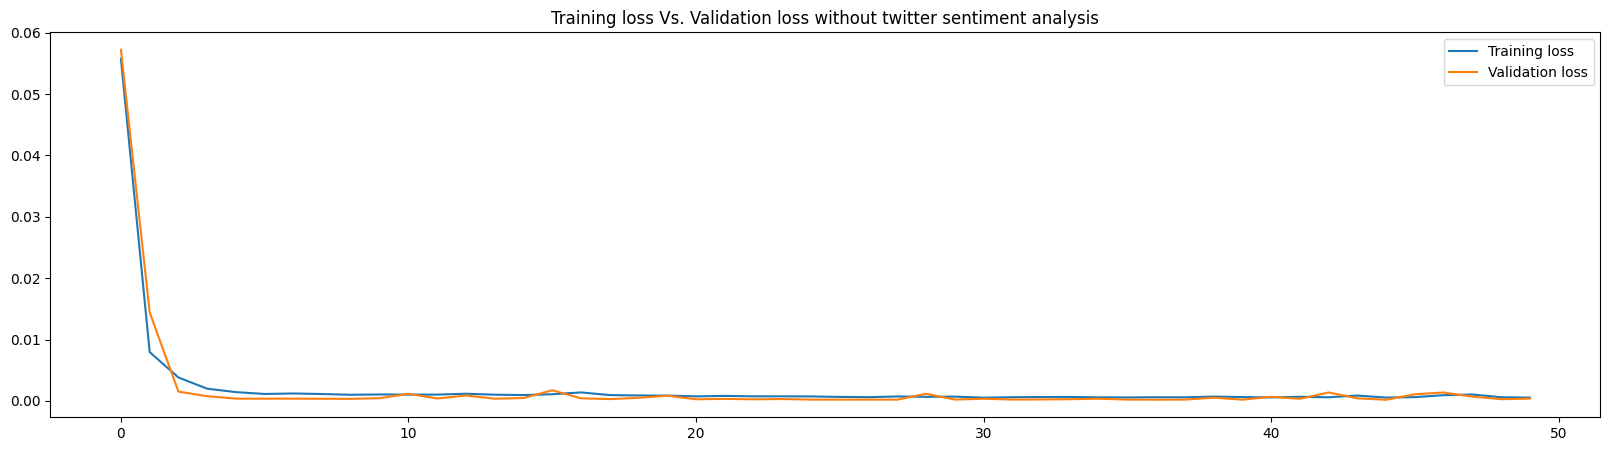

In [14]:
plt.figure(figsize=(20,5))
plt.plot(history_without_twitter.history['loss'], label='Training loss')
plt.plot(history_without_twitter.history['val_loss'], label='Validation loss')
plt.title('Training loss Vs. Validation loss without twitter sentiment analysis')
plt.legend()


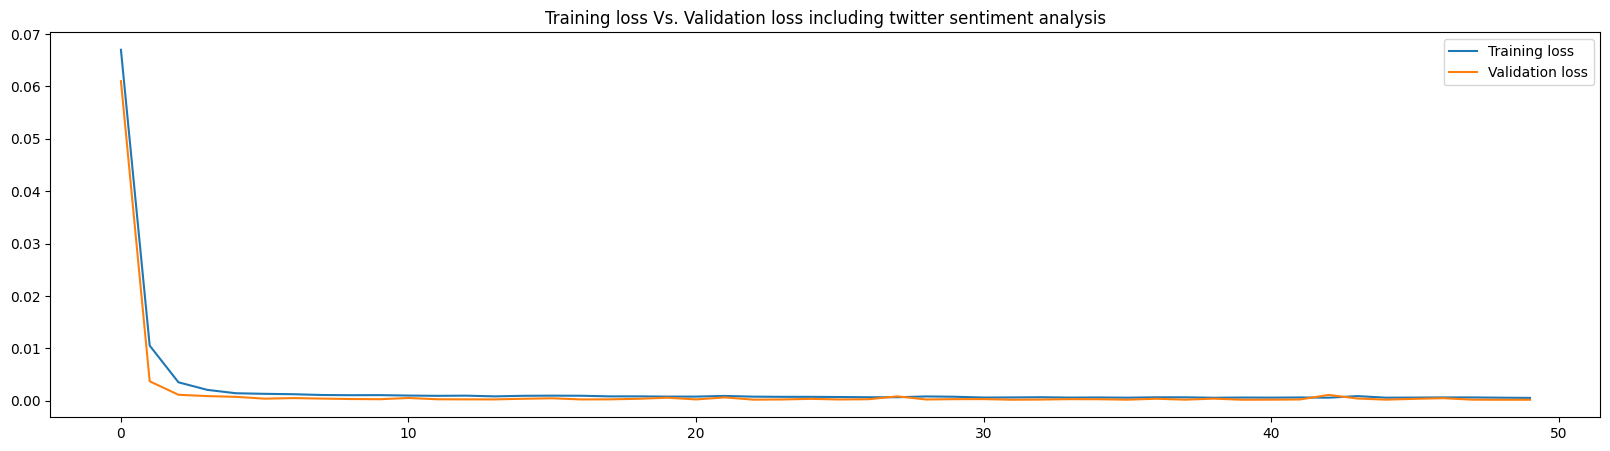

In [15]:
plt.figure(figsize=(20,5))
plt.plot(history_twitter.history['loss'], label='Training loss')
plt.plot(history_twitter.history['val_loss'], label='Validation loss')
plt.title('Training loss Vs. Validation loss including twitter sentiment analysis')
plt.legend()

## Plotting

In [16]:
from sklearn.metrics import mean_squared_error,mean_absolute_error
from math import sqrt

def plot_predictions_with_dates (type,twitter,dates,y_actual_lstm,y_pred_lstm):
    predicted_features=['Open','Adj Close']
    for i,predicted_feature in enumerate(predicted_features):
        plt.figure(figsize=(15,6))
        if twitter :
            plt.title(f'LSTM {type} prediction of {predicted_feature} feature After adding twitter sentiment analysis')
        else:
            plt.title(f'LSTM {type} prediction of {predicted_feature} feature without twitter sentiment analysis')
        sns.lineplot(x=dates, y=y_actual_lstm[:,i],label='Actual')
        sns.lineplot(x=dates, y=y_pred_lstm[:, i], label='Predicted')
        plt.show()
        error=mean_squared_error(y_actual_lstm[:,i], y_pred_lstm[:, i])
        print(f'Mean square error for {predicted_feature} ={error}')
    print('Total mean square error', mean_squared_error(y_actual_lstm, y_pred_lstm))

# Computing training accuracy

In [17]:
training_dates= df_for_training.index[:X_train_lstm_without_twitter.shape[0]]
#Make prediction
training_prediction_without_twitter = cnn_lstm_model_without_twitter.predict(X_train_lstm_without_twitter)

training_prediction_twitter = cnn_lstm_model_twitter.predict(X_train_lstm_twitter)

training_prediction_without_twitter=training_prediction_without_twitter.reshape(training_prediction_without_twitter.shape[0], training_prediction_without_twitter.shape[2])

training_prediction_twitter=training_prediction_twitter.reshape(training_prediction_twitter.shape[0], training_prediction_twitter.shape[2])

y_train_pred_lstm_without_twitter = scaler_for_inference.inverse_transform(training_prediction_without_twitter)

y_train_pred_lstm_twitter = scaler_for_inference.inverse_transform(training_prediction_twitter)

y_train_lstm_reshaped_without_twitter=y_train_lstm_without_twitter.reshape(y_train_lstm_without_twitter.shape[0], y_train_lstm_without_twitter.shape[2])

y_train_actual_lstm = scaler_for_inference.inverse_transform(y_train_lstm_reshaped_without_twitter)



26/26 [==============================] - 1s 7ms/step


####  Training accuracy without twitter

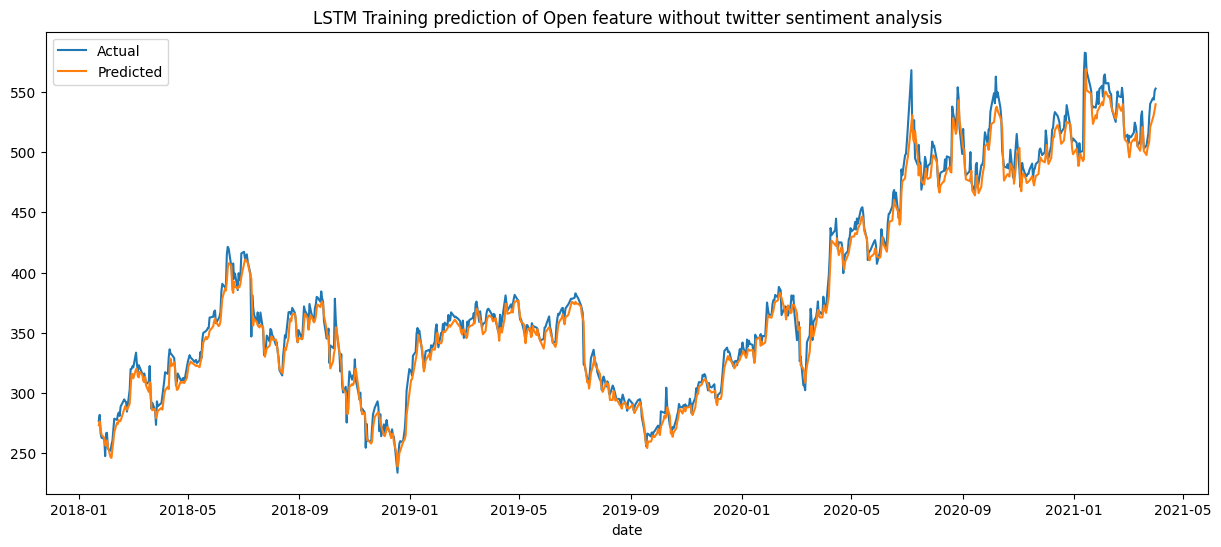

Mean square error for Open =96.01341351638739


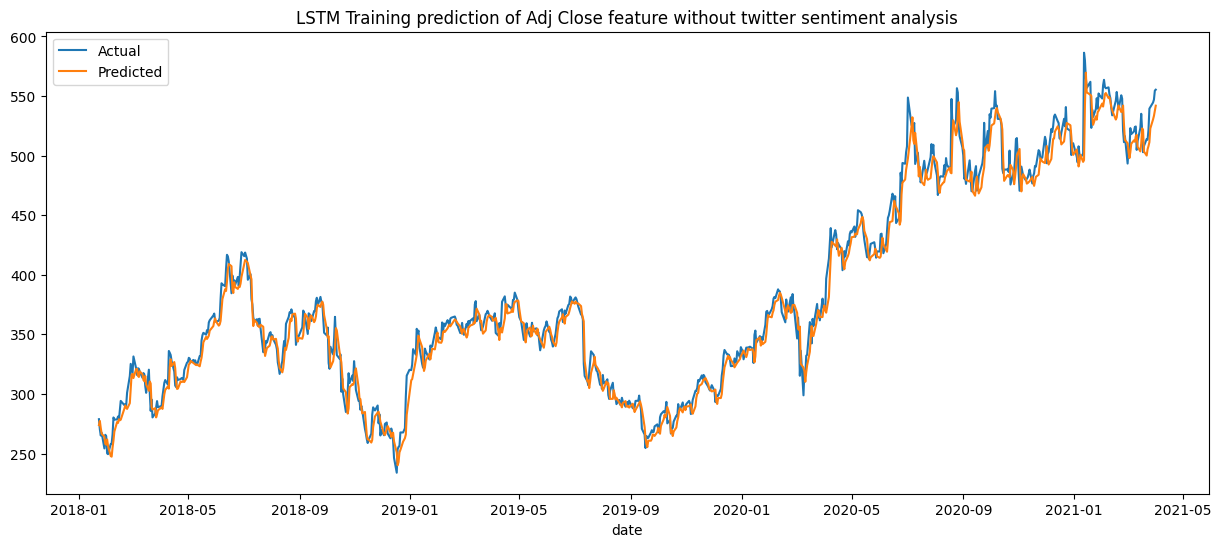

Mean square error for Adj Close =139.5964226191953
Total mean square error 117.80491806779129


In [18]:
plot_predictions_with_dates('Training',False,training_dates,y_train_actual_lstm,y_train_pred_lstm_without_twitter)

#### Training accuracy after adding the impact of twitter sentiment analysis

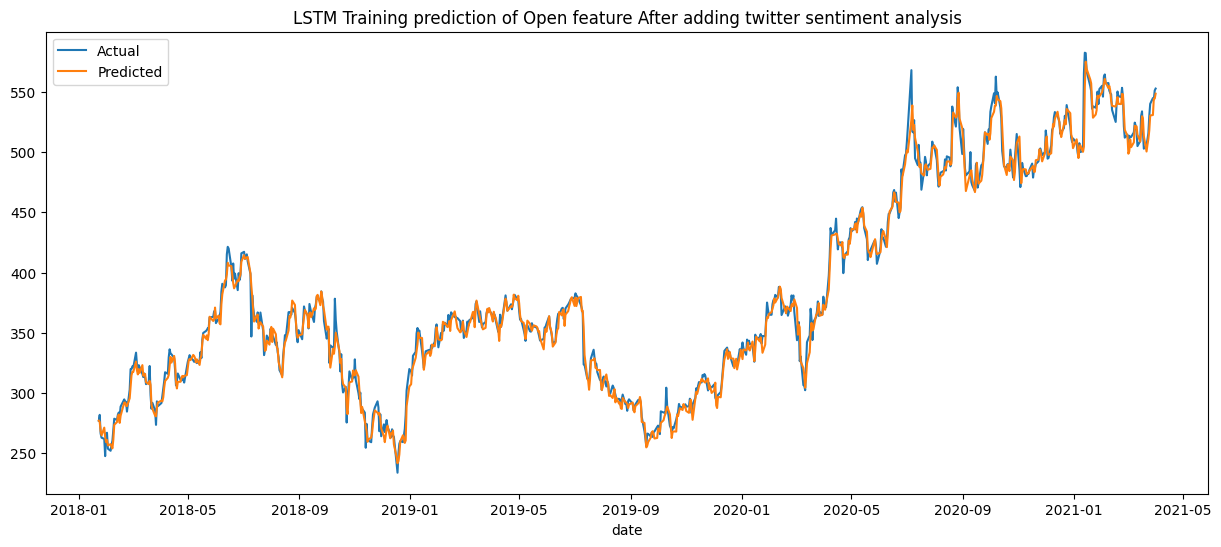

Mean square error for Open =58.5525894075082


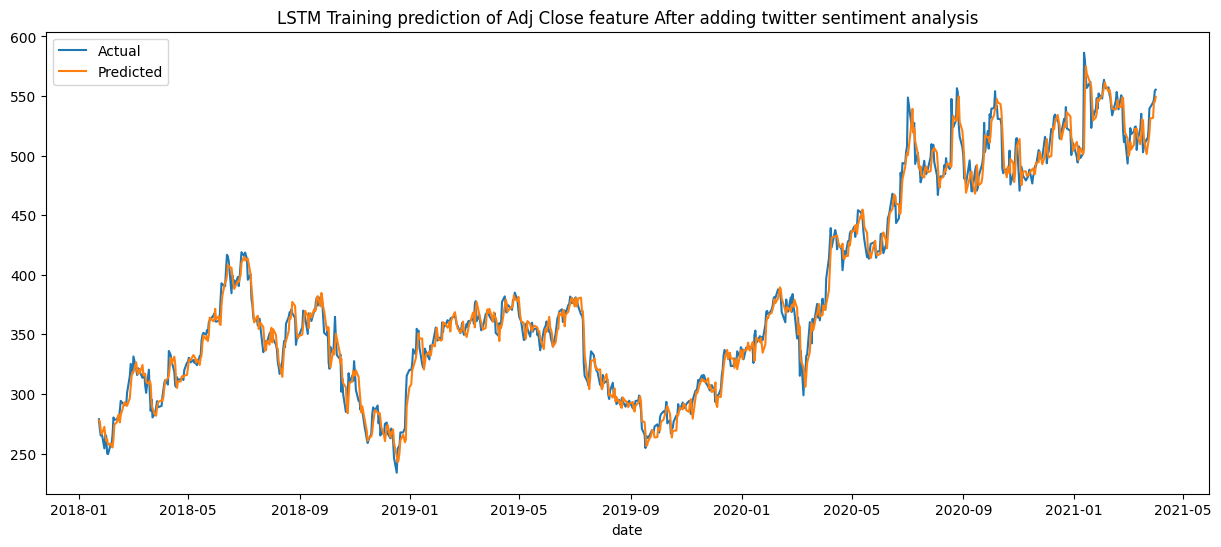

Mean square error for Adj Close =113.28229016135951
Total mean square error 85.91743978443381


In [19]:
plot_predictions_with_dates('Training',True,training_dates,y_train_actual_lstm,y_train_pred_lstm_twitter)

## Computing validation accuracy

In [20]:
validation_dates= df_for_training.index[X_train_lstm_without_twitter.shape[0]:X_train_lstm_without_twitter.shape[0] + X_val_lstm_without_twitter.shape[0]]
#Make prediction
validation_prediction_without_twitter = cnn_lstm_model_without_twitter.predict(X_val_lstm_without_twitter)

validation_prediction_twitter = cnn_lstm_model_twitter.predict(X_val_lstm_twitter)

validation_prediction_without_twitter=validation_prediction_without_twitter.reshape(validation_prediction_without_twitter.shape[0], validation_prediction_without_twitter.shape[2])


validation_prediction_twitter=validation_prediction_twitter.reshape(validation_prediction_twitter.shape[0], validation_prediction_twitter.shape[2])


y_val_pred_lstm_without_twitter = scaler_for_inference.inverse_transform(validation_prediction_without_twitter)
y_val_pred_lstm_twitter = scaler_for_inference.inverse_transform(validation_prediction_twitter)

y_val_actual_lstm_reshaped_without_twitter=y_val_lstm_without_twitter.reshape(y_val_lstm_without_twitter.shape[0], y_val_lstm_without_twitter.shape[2])

y_val_actual_lstm = scaler_for_inference.inverse_transform(y_val_actual_lstm_reshaped_without_twitter)



3/3 [==============================] - 0s 6ms/step


#### Validation accuracy without twitter

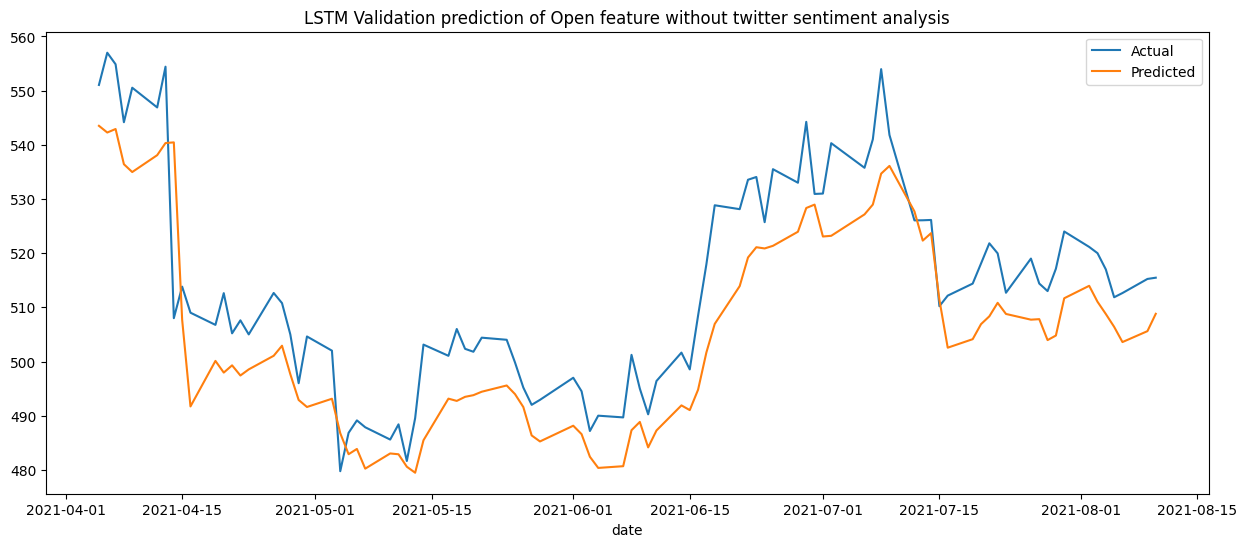

Mean square error for Open =112.75705703949151


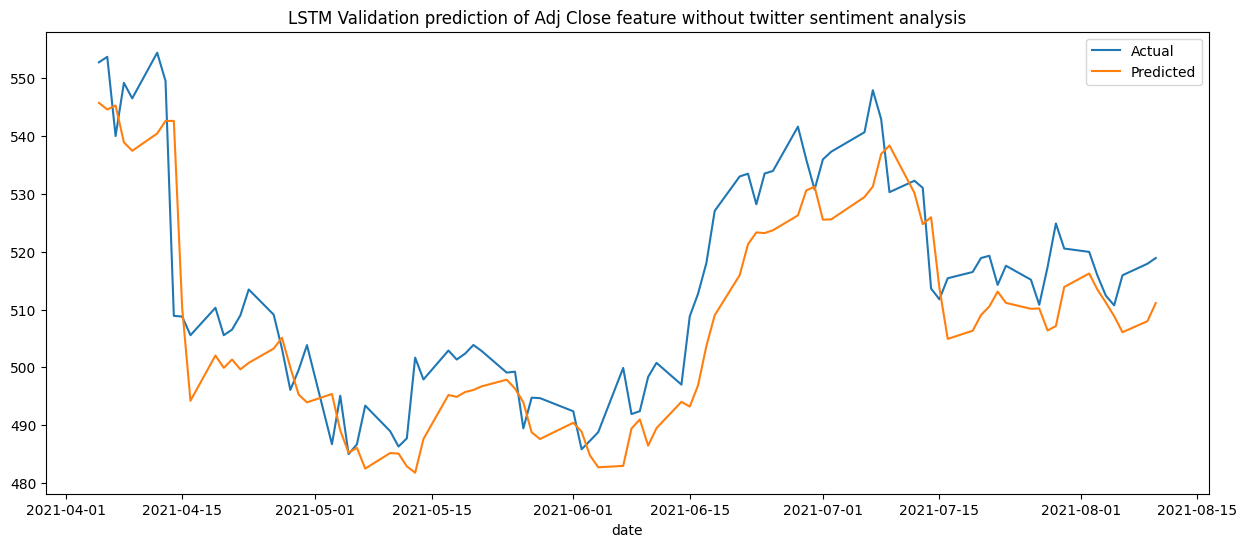

Mean square error for Adj Close =92.31779078762213
Total mean square error 102.53742391355684


In [21]:
plot_predictions_with_dates('Validation',False,validation_dates,y_val_actual_lstm,y_val_pred_lstm_without_twitter)

#### Validation accuracy after adding the impact of twitter sentiment analysis

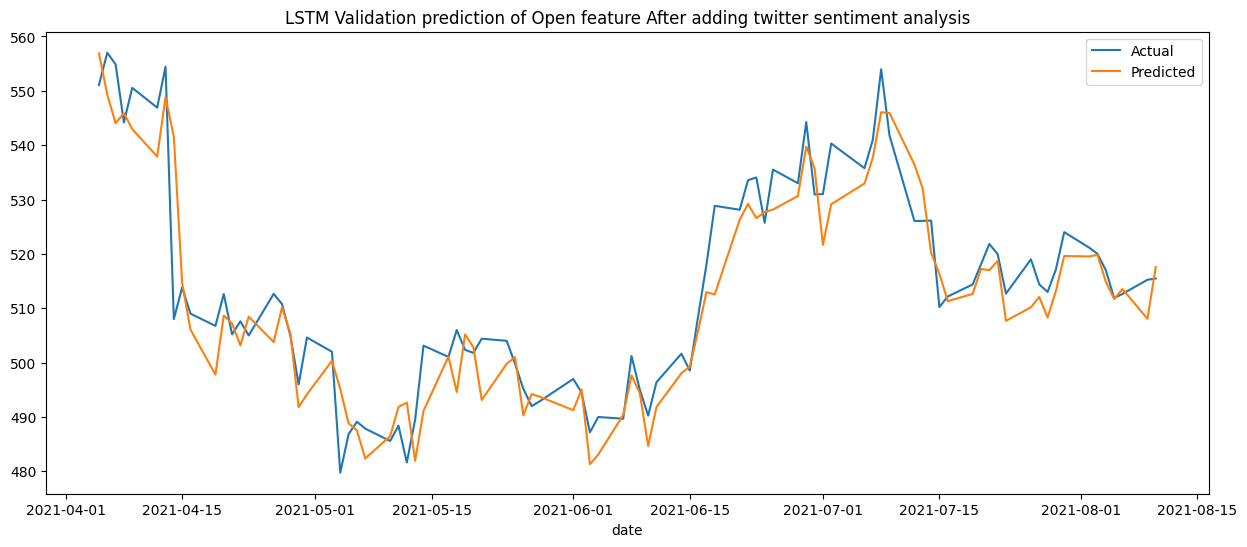

Mean square error for Open =47.18382938085806


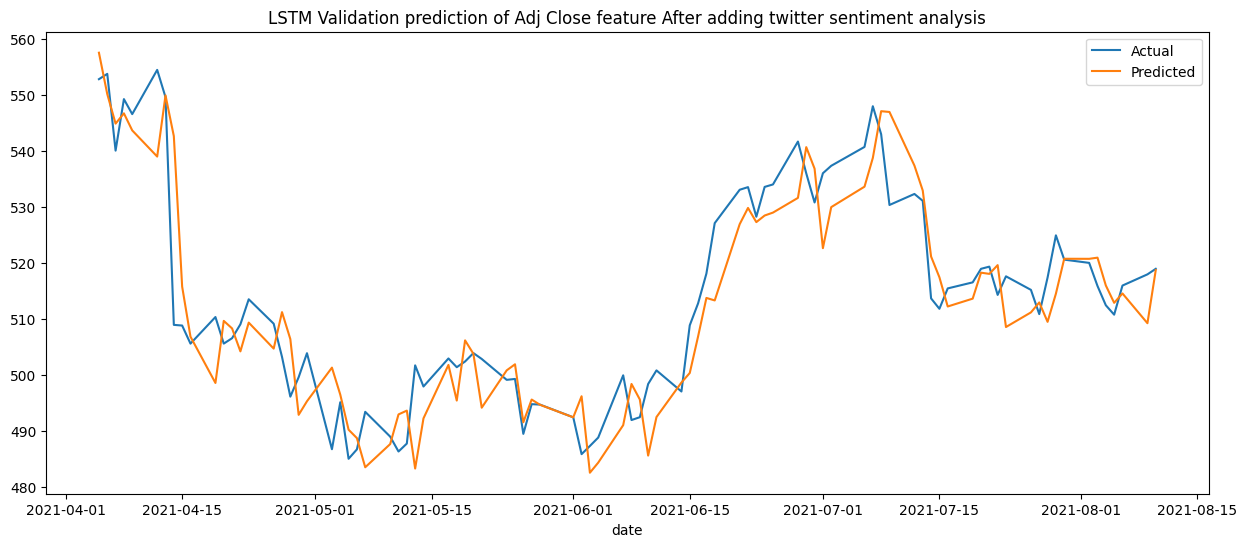

Mean square error for Adj Close =58.48980618248249
Total mean square error 52.83681778167028


In [22]:
plot_predictions_with_dates('Validation',True,validation_dates,y_val_actual_lstm,y_val_pred_lstm_twitter)

## Computing testing accuracy

In [23]:
testing_dates= df_for_training.index[-X_test_lstm_without_twitter.shape[0]:]
#Make prediction
testing_prediction_without_twitter = cnn_lstm_model_without_twitter.predict(X_test_lstm_without_twitter)
testing_prediction_twitter = cnn_lstm_model_twitter.predict(X_test_lstm_twitter)

testing_prediction_without_twitter=testing_prediction_without_twitter.reshape(testing_prediction_without_twitter.shape[0], testing_prediction_without_twitter.shape[2])
testing_prediction_twitter=testing_prediction_twitter.reshape(testing_prediction_twitter.shape[0], testing_prediction_twitter.shape[2])

y_test_pred_lstm_without_twitter = scaler_for_inference.inverse_transform(testing_prediction_without_twitter)
y_test_pred_lstm_twitter = scaler_for_inference.inverse_transform(testing_prediction_twitter)

y_test_actual_lstm_reshaped_without_twitter=y_test_lstm_without_twitter.reshape(y_test_lstm_without_twitter.shape[0], y_test_lstm_without_twitter.shape[2])


y_test_actual_lstm = scaler_for_inference.inverse_transform(y_test_actual_lstm_reshaped_without_twitter)



7/7 [==============================] - 0s 4ms/step


#### Testing accuracy without twitter

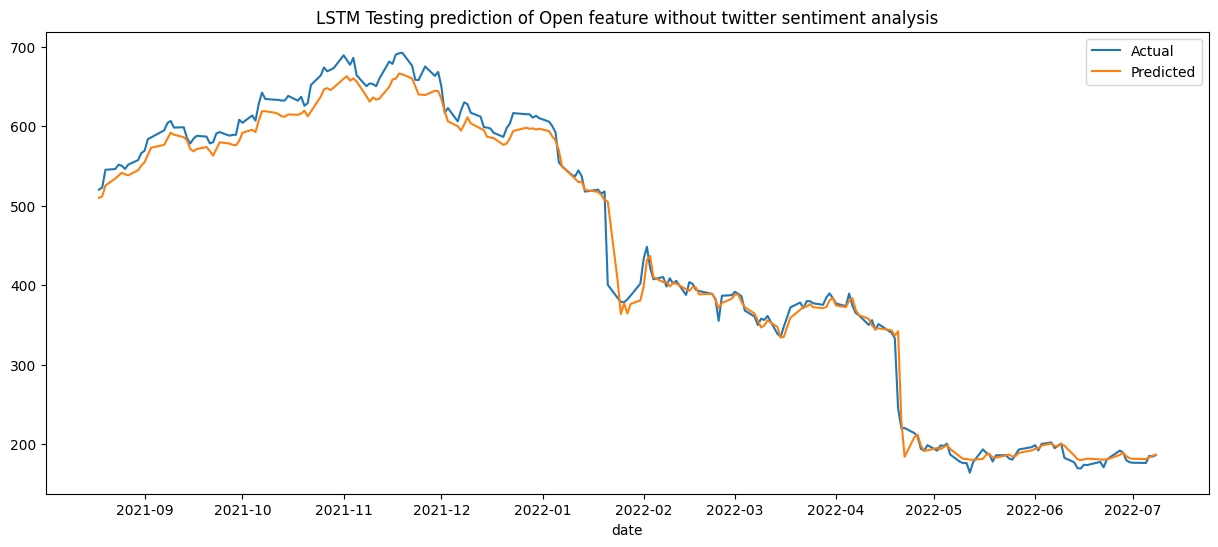

Mean square error for Open =278.19812716242586


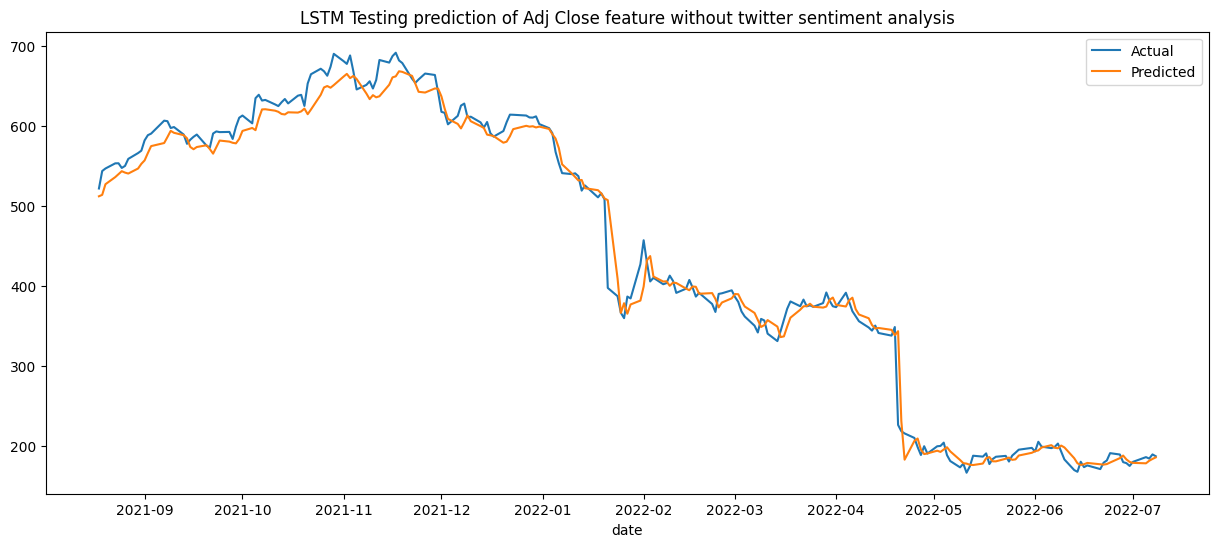

Mean square error for Adj Close =352.6723093674423
Total mean square error 315.43521826493406


In [24]:
plot_predictions_with_dates('Testing',False,testing_dates,y_test_actual_lstm,y_test_pred_lstm_without_twitter)

#### Testing accuracy after adding the impact of twitter sentiment analysis

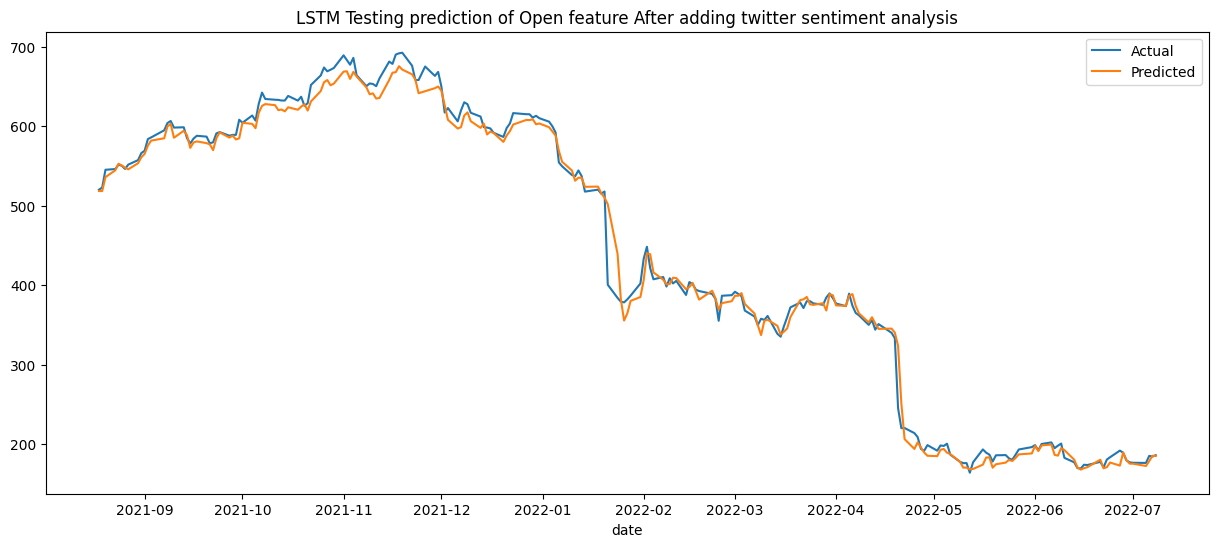

Mean square error for Open =192.20498663850245


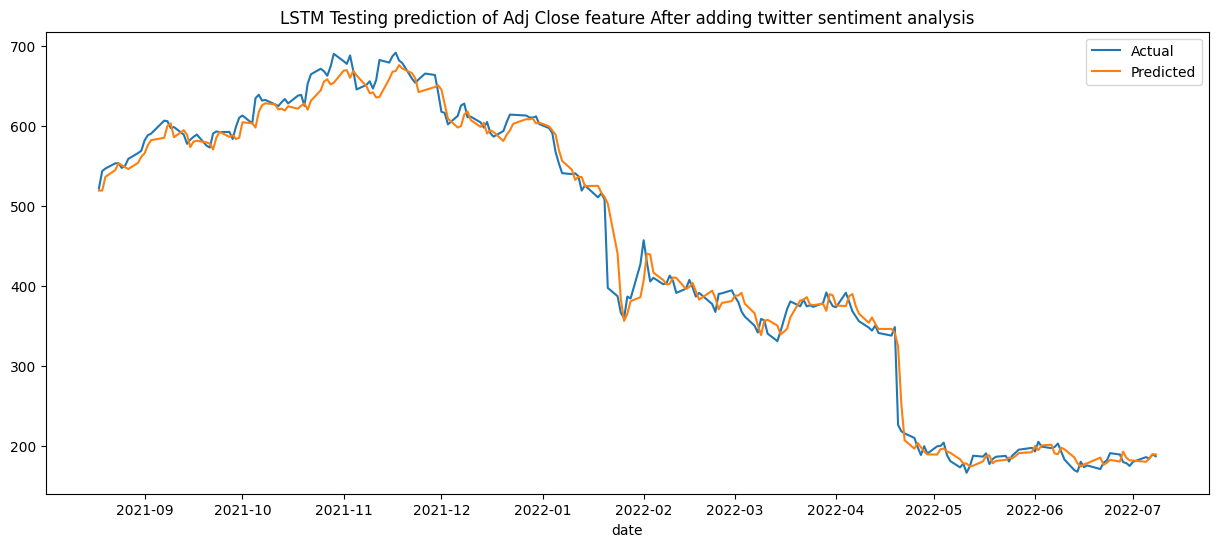

Mean square error for Adj Close =293.15510682779484
Total mean square error 242.68004673314866


In [25]:
plot_predictions_with_dates('Testing',True,testing_dates,y_test_actual_lstm,y_test_pred_lstm_twitter)

# ARIMA

In [26]:
!pip install pmdarima==1.8.1

## Train test split for Arima

In [27]:
df_arima=df_for_training.copy()
# df_arima['Volume']=df['Volume']
n_past_for_arima=1
adj_close_feature=df_arima['Adj Close']
open_feature=df_arima['Open']
df_arima['Adj Close']=df_arima['Adj Close'].shift(-n_past_for_arima)
df_arima['Open']=df_arima['Open'].shift(-n_past_for_arima)
df_arima.dropna(inplace=True)
df_arima['Adj Close_feature']=adj_close_feature.iloc[:-1]
df_arima['open_feature_feature']=open_feature.iloc[:-1]
# df_arima=df_arima.reindex(columns=['open_lag','High', 'Low', 'Close', 'adj_close_lag','P_mean','Adj Close','Open',])
X_arima=df_arima.drop(['Adj Close','Open'],axis=1)
y_arima=df_arima[['Open','Adj Close']]
X_train_arima_twitter, X_test_arima_twitter, y_train_arima, y_test_arima=train_test_split(X_arima, y_arima, test_size=0.2, shuffle=False)

X_train_arima_without_twitter, X_test_arima_without_twitter= X_train_arima_twitter.drop('P_mean', axis=1), X_test_arima_twitter.drop('P_mean', axis=1)
X_train_arima_without_twitter


,High,Low,Close,Volume,Adj Close_feature,open_feature_feature
date,,,,,,
2018-01-23,257.709991,248.020004,250.289993,27705300.0,250.289993,255.050003
2018-01-24,261.709991,249.309998,261.299988,17352400.0,261.299988,250.880005
2018-01-25,272.299988,260.230011,269.700012,15336400.0,269.700012,263.000000
2018-01-26,274.600006,268.760010,274.600006,11021800.0,274.600006,271.489990
2018-01-29,286.809998,273.920013,284.589996,17529700.0,284.589996,274.200012
...,...,...,...,...,...,...
2021-08-09,522.669983,517.989990,519.969971,1367800.0,519.969971,521.150024
2021-08-10,520.789978,512.969971,515.840027,1960500.0,515.840027,520.000000
2021-08-11,519.570007,509.769989,512.400024,1673900.0,512.400024,517.000000


In [28]:
X_train_arima_twitter

,High,Low,Close,Volume,P_mean,Adj Close_feature,open_feature_feature
date,,,,,,,
2018-01-23,257.709991,248.020004,250.289993,27705300.0,-0.061196,250.289993,255.050003
2018-01-24,261.709991,249.309998,261.299988,17352400.0,-0.084525,261.299988,250.880005
2018-01-25,272.299988,260.230011,269.700012,15336400.0,-0.122744,269.700012,263.000000
2018-01-26,274.600006,268.760010,274.600006,11021800.0,-0.118012,274.600006,271.489990
2018-01-29,286.809998,273.920013,284.589996,17529700.0,-0.100690,284.589996,274.200012
...,...,...,...,...,...,...,...
2021-08-09,522.669983,517.989990,519.969971,1367800.0,-0.051282,519.969971,521.150024
2021-08-10,520.789978,512.969971,515.840027,1960500.0,-0.085427,515.840027,520.000000
2021-08-11,519.570007,509.769989,512.400024,1673900.0,-0.058824,512.400024,517.000000


## Arima model to predict open prices

In [29]:
from pmdarima import auto_arima
arima_model_for_open_without_twitter = auto_arima(y_train_arima['Open'], exogenous=X_train_arima_without_twitter,
                                                  start_p=2, d=None, start_q=3, max_p=5, max_d=3, max_q=5, D=None, start_Q=1, max_P=2, max_D=1, max_Q=2, max_order=5,
                                                  seasonal=True,
                                                  error_action='ignore',
                                                  suppress_warnings=True,
                                                  stepwise=True
                                                  )

arima_model_for_open_twitter = auto_arima(y_train_arima['Open'], exogenous=X_train_arima_twitter,
                                          start_p=2, d=None, start_q=3, max_p=5, max_d=3, max_q=5, D=None, start_Q=1, max_P=2, max_D=1, max_Q=2, max_order=5,
                                          seasonal=True,
                                          error_action='ignore',
                                          suppress_warnings=True,
                                          stepwise=True
                                          )
arima_model_for_open_without_twitter.summary()
arima_model_for_open_twitter.summary()

/usr/local/lib/python3.10/dist-packages/sklearn/utils/metaestimators.py:121: FutureWarning: if_delegate_has_method was deprecated in version 1.1 and will be removed in version 1.3. Use available_if instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/metaestimators.py:121: FutureWarning: if_delegate_has_method was deprecated in version 1.1 and will be removed in version 1.3. Use available_if instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/metaestimators.py:121: FutureWarning: if_delegate_has_method was deprecated in version 1.1 and will be removed in version 1.3. Use available_if instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/metaestimators.py:121: FutureWarning: if_delegate_has_method was deprecated in version 1.1 and will be removed in version 1.3. Use available_if instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/metaestimators.py:121: FutureWarning: if_delegate_

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  897
Model:               SARIMAX(1, 0, 0)   Log Likelihood               -2838.817
Date:                Wed, 27 Mar 2024   AIC                           5695.633
Time:                        06:01:41   BIC                           5738.825
Sample:                             0   HQIC                          5712.135
                                - 897                                         
Covariance Type:                  opg                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
High                     0.2382      0.046      5.172      0.000       0.148       0.329
Low                      0.2634      0.039      6.734      0.000       0.187       0.340
Close                    0.3585      0.020     17.816      0.000       0.319       0.398
Volume                6.975e-08   2.82e-08      2.477      0.013    1.46e-08    1.25e-07
P_mean                  18.1088      0.038    472.421      0.000      18.034      18.184
Adj Close_feature        0.3585      0.020     17.816      0.000       0.319       0.398
open_feature_feature    -0.2159      0.042     -5.125      0.000      -0.298      -0.133
ar.L1                   -0.0509      0.035     -1.449      0.147      -0.120       0.018
sigma2                  32.8771      0.403     81.642      0.000      32.088      33.666
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             33445.31
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.43   Skew:                            -0.42
Prob(H) (two-sided):                  0.00   Kurtosis:                        32.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.35e+19. Standard errors may be unstable.
"""

## Computing training accuracy for open prices

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


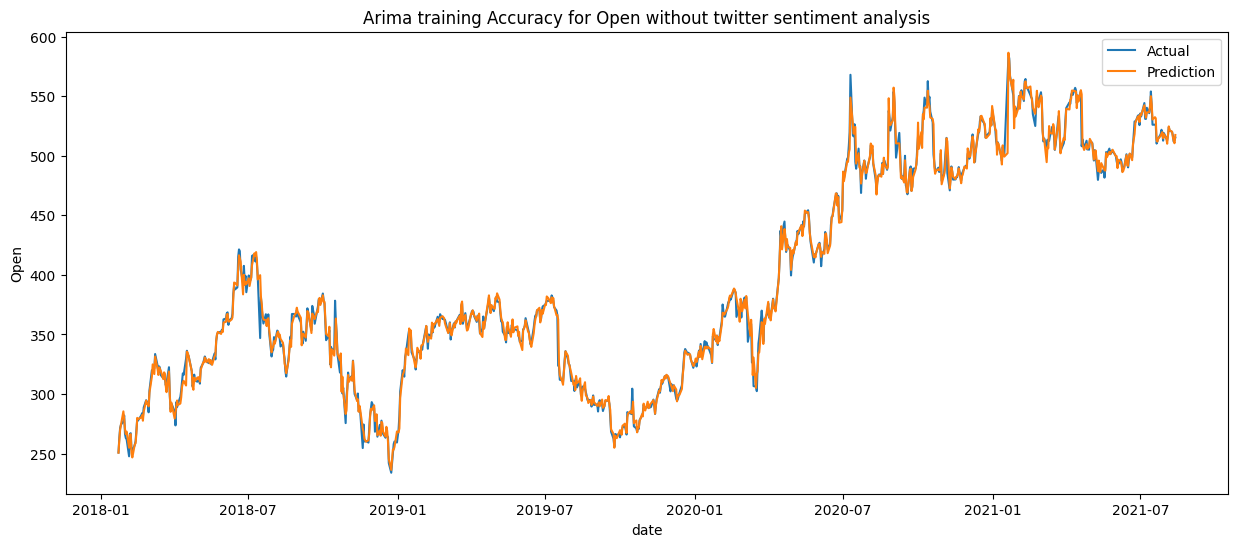

Training mean square error for open feature without twitter 33.613454309183204


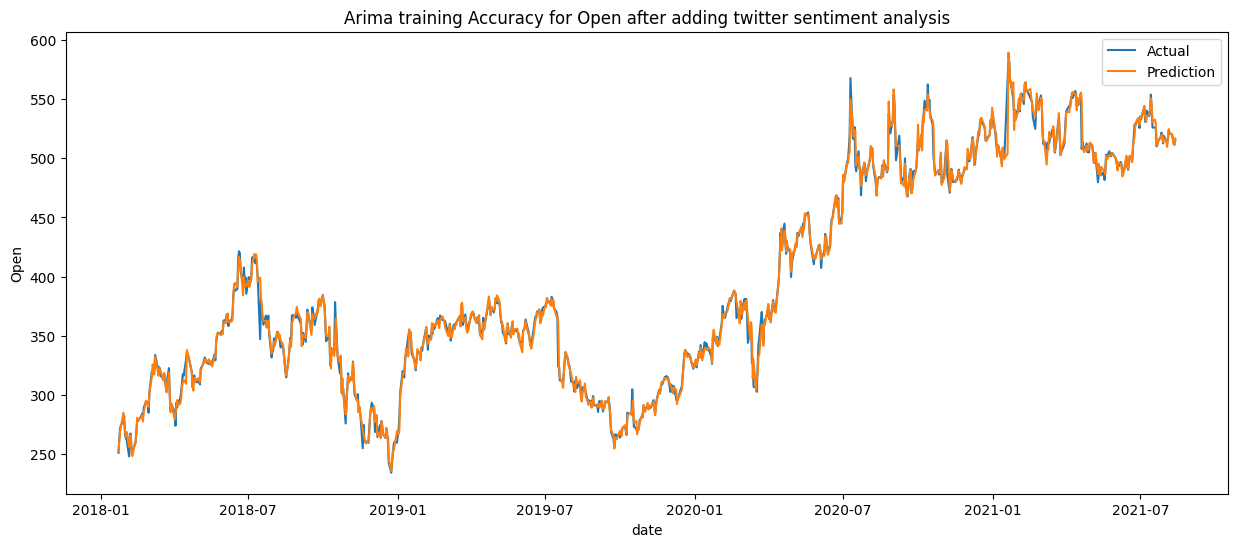

Training mean square error for open feature with twitter 32.92725302711501


In [30]:
from sklearn.metrics import mean_squared_error,mean_absolute_error
train_prediction_without_twitter= arima_model_for_open_without_twitter.predict(n_periods=len(X_train_arima_without_twitter), exogenous=X_train_arima_without_twitter)
train_prediction_twitter= arima_model_for_open_twitter.predict(n_periods=len(X_train_arima_twitter), exogenous=X_train_arima_twitter)
plt.figure(figsize=(15,6))
sns.lineplot(x=y_train_arima['Open'].index, y=y_train_arima['Open'], label='Actual')
sns.lineplot(x=y_train_arima['Open'].index, y=train_prediction_without_twitter, label='Prediction')
plt.title('Arima training Accuracy for Open without twitter sentiment analysis')
plt.show()
e=mean_squared_error(train_prediction_without_twitter, y_train_arima['Open'])
print(f'Training mean square error for open feature without twitter {e}')

plt.figure(figsize=(15,6))
sns.lineplot(x=y_train_arima['Open'].index, y=y_train_arima['Open'], label='Actual')
sns.lineplot(x=y_train_arima['Open'].index, y=train_prediction_twitter, label='Prediction')
plt.title('Arima training Accuracy for Open after adding twitter sentiment analysis')
plt.show()
e=mean_squared_error(train_prediction_twitter, y_train_arima['Open'])
print(f'Training mean square error for open feature with twitter {e}')


## Computing testing accuracy for open prices

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


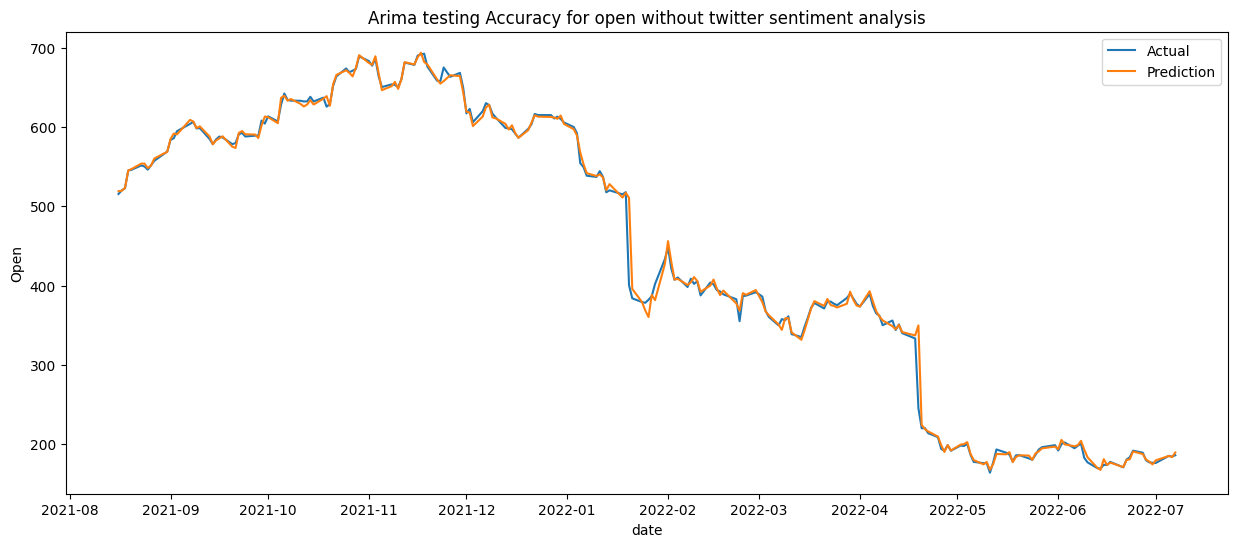

Testing mean square error for open feature without twitter sentiment analysis 123.59182698126213


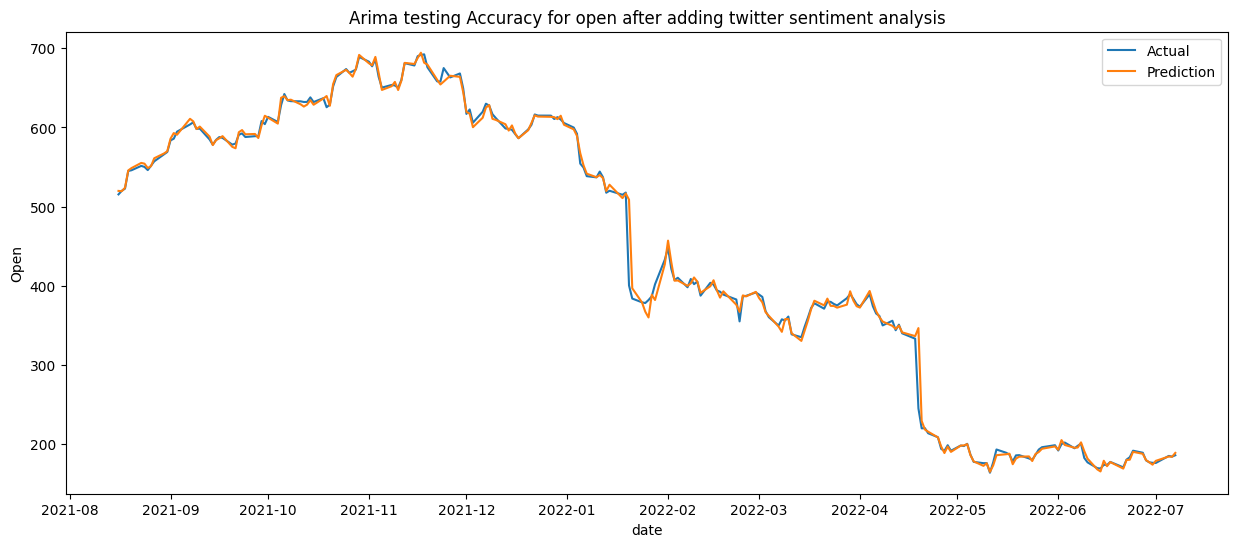

Testing mean square error for open feature with twitter sentiment analysis 120.65598753207615


In [31]:
from sklearn.metrics import mean_squared_error,mean_absolute_error
test_prediction_without_twitter= arima_model_for_open_without_twitter.predict(n_periods=len(X_test_arima_without_twitter), exogenous=X_test_arima_without_twitter)
test_prediction_twitter= arima_model_for_open_twitter.predict(n_periods=len(X_test_arima_twitter), exogenous=X_test_arima_twitter)
plt.figure(figsize=(15,6))
sns.lineplot(x=y_test_arima['Open'].index, y=y_test_arima['Open'], label='Actual')
sns.lineplot(x=y_test_arima['Open'].index, y=test_prediction_without_twitter, label='Prediction')
plt.title('Arima testing Accuracy for open without twitter sentiment analysis')
plt.show()
e=mean_squared_error(test_prediction_without_twitter, y_test_arima['Open'])
print(f'Testing mean square error for open feature without twitter sentiment analysis {e}')

plt.figure(figsize=(15,6))
sns.lineplot(x=y_test_arima['Open'].index, y=y_test_arima['Open'], label='Actual')
sns.lineplot(x=y_test_arima['Open'].index, y=test_prediction_twitter, label='Prediction')
plt.title('Arima testing Accuracy for open after adding twitter sentiment analysis')
plt.show()
e=mean_squared_error(test_prediction_twitter, y_test_arima['Open'])
print(f'Testing mean square error for open feature with twitter sentiment analysis {e}')


## Arima model for Adjusted Close prices

In [32]:
from pmdarima import auto_arima
arima_model_for_Adj_Close_without_twitter = auto_arima(y_train_arima['Adj Close'], exogenous=X_train_arima_without_twitter,
                                                  start_p=2, d=None, start_q=3, max_p=5, max_d=3, max_q=5, D=None, start_Q=1, max_P=2, max_D=1, max_Q=2, max_order=5,
                                                  seasonal=True,
                                                  error_action='ignore',
                                                  suppress_warnings=True,
                                                  stepwise=True
                                                  )

arima_model_for_Adj_Close_twitter = auto_arima(y_train_arima['Adj Close'], exogenous=X_train_arima_twitter,
                                          start_p=2, d=None, start_q=3, max_p=5, max_d=3, max_q=5, D=None, start_Q=1, max_P=2, max_D=1, max_Q=2, max_order=5,
                                          seasonal=True,
                                          error_action='ignore',
                                          suppress_warnings=True,
                                          stepwise=True
                                          )
arima_model_for_Adj_Close_without_twitter.summary()
arima_model_for_Adj_Close_twitter.summary()

/usr/local/lib/python3.10/dist-packages/sklearn/utils/metaestimators.py:121: FutureWarning: if_delegate_has_method was deprecated in version 1.1 and will be removed in version 1.3. Use available_if instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/metaestimators.py:121: FutureWarning: if_delegate_has_method was deprecated in version 1.1 and will be removed in version 1.3. Use available_if instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/metaestimators.py:121: FutureWarning: if_delegate_has_method was deprecated in version 1.1 and will be removed in version 1.3. Use available_if instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/metaestimators.py:121: FutureWarning: if_delegate_has_method was deprecated in version 1.1 and will be removed in version 1.3. Use available_if instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/metaestimators.py:121: FutureWarning: if_delegate_

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  897
Model:               SARIMAX(1, 0, 1)   Log Likelihood               -3341.971
Date:                Wed, 27 Mar 2024   AIC                           6703.943
Time:                        06:02:30   BIC                           6751.934
Sample:                             0   HQIC                          6722.279
                                - 897                                         
Covariance Type:                  opg                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
High                     0.2323      0.086      2.700      0.007       0.064       0.401
Low                      0.3596      0.083      4.316      0.000       0.196       0.523
Close                    0.2830      0.042      6.701      0.000       0.200       0.366
Volume                7.037e-08   5.46e-08      1.288      0.198   -3.67e-08    1.77e-07
P_mean                  18.1960      0.003   5432.620      0.000      18.189      18.203
Adj Close_feature        0.2830      0.042      6.701      0.000       0.200       0.366
open_feature_feature    -0.1537      0.081     -1.903      0.057      -0.312       0.005
ar.L1                    0.7182      0.235      3.056      0.002       0.258       1.179
ma.L1                   -0.7647      0.211     -3.630      0.000      -1.178      -0.352
sigma2                 100.9217      0.008   1.27e+04      0.000     100.906     100.937
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              2068.98
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.82   Skew:                             0.45
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.94e+19. Standard errors may be unstable.
"""

## Computing training accuracy for Adjusted Close prices

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


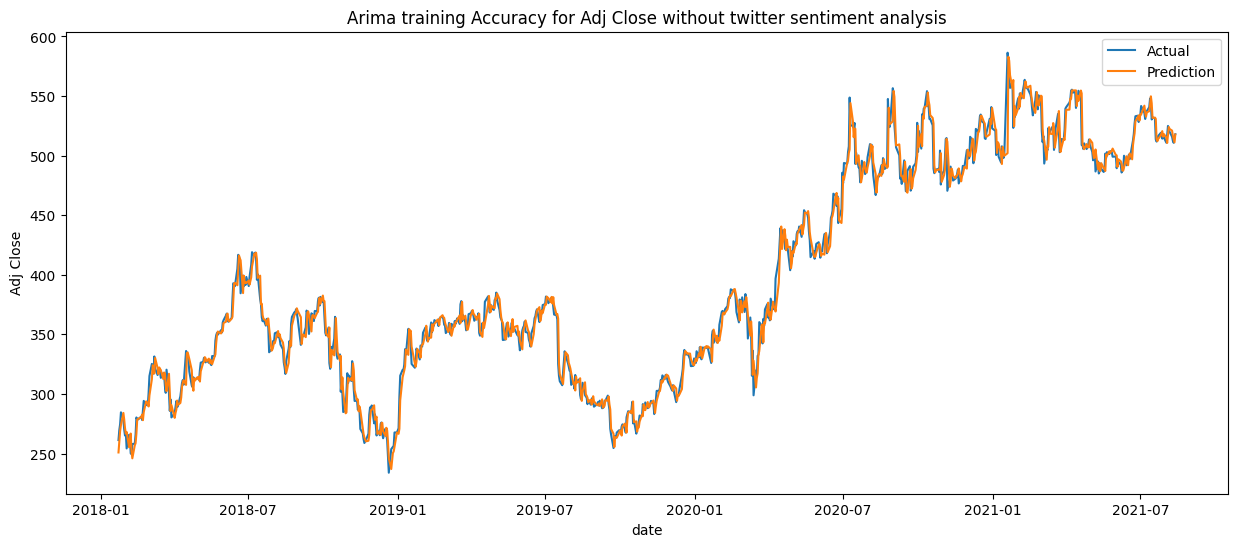

Training mean absolute error for Adj Close feature without twitter 101.92379161192359


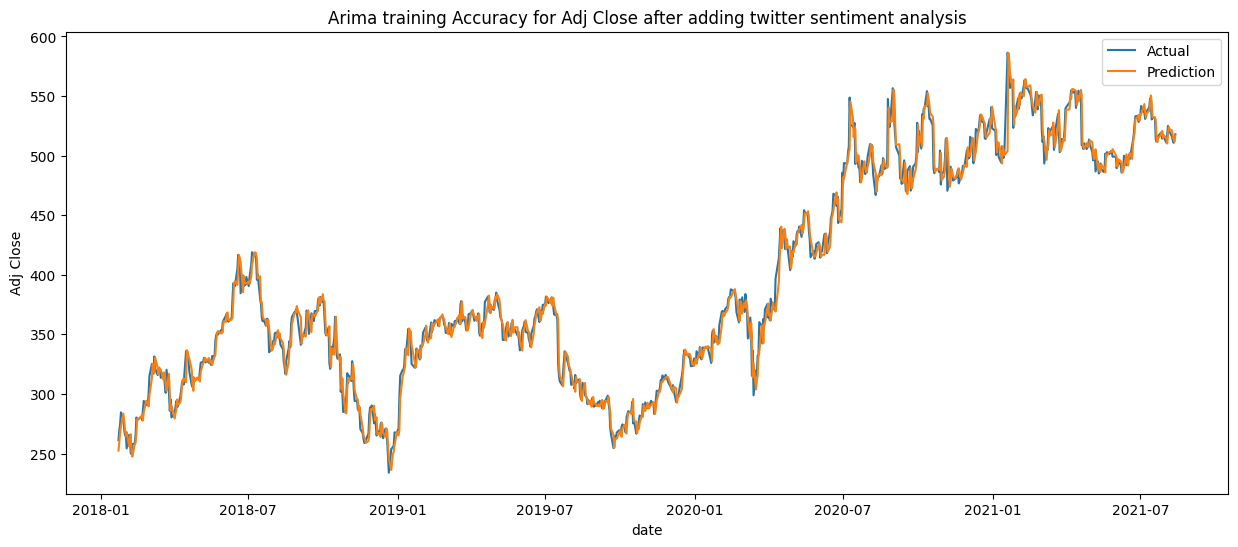

Training mean absolute error for Adj Close feature with twitter 101.26964328937957


In [33]:
from sklearn.metrics import mean_squared_error,mean_absolute_error
train_prediction_without_twitter= arima_model_for_Adj_Close_without_twitter.predict(n_periods=len(X_train_arima_without_twitter), exogenous=X_train_arima_without_twitter)
train_prediction_twitter= arima_model_for_Adj_Close_twitter.predict(n_periods=len(X_train_arima_twitter), exogenous=X_train_arima_twitter)
plt.figure(figsize=(15,6))
sns.lineplot(x=y_train_arima['Adj Close'].index, y=y_train_arima['Adj Close'], label='Actual')
sns.lineplot(x=y_train_arima['Adj Close'].index, y=train_prediction_without_twitter, label='Prediction')
plt.title('Arima training Accuracy for Adj Close without twitter sentiment analysis')
plt.show()
e=mean_squared_error(train_prediction_without_twitter, y_train_arima['Adj Close'])
print(f'Training mean absolute error for Adj Close feature without twitter {e}')

plt.figure(figsize=(15,6))
sns.lineplot(x=y_train_arima['Adj Close'].index, y=y_train_arima['Adj Close'], label='Actual')
sns.lineplot(x=y_train_arima['Adj Close'].index, y=train_prediction_twitter, label='Prediction')
plt.title('Arima training Accuracy for Adj Close after adding twitter sentiment analysis')
plt.show()
e=mean_squared_error(train_prediction_twitter, y_train_arima['Adj Close'])
print(f'Training mean absolute error for Adj Close feature with twitter {e}')


## Computing testing accuracy for Adjusted close prices

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


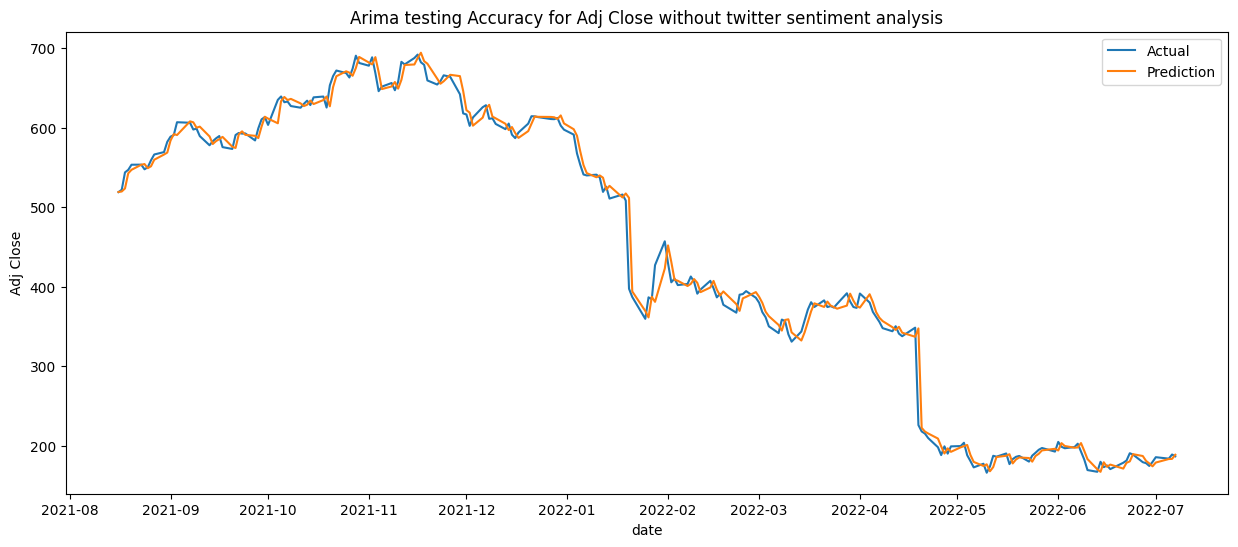

Testing absolute mean square error for Adj Close feature without twitter sentiment analysis 236.1959848614592


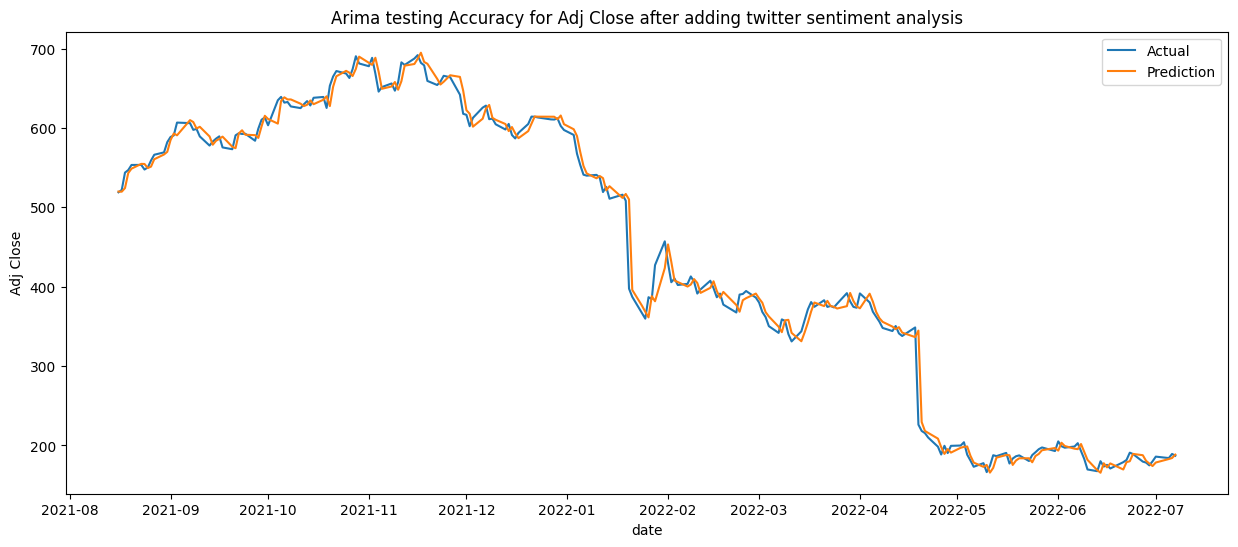

Testing absolute mean square error for Adj Close  feature with twitter sentiment analysis 232.88280551994052


In [34]:
from sklearn.metrics import mean_squared_error,mean_absolute_error
test_prediction_without_twitter= arima_model_for_Adj_Close_without_twitter.predict(n_periods=len(X_test_arima_without_twitter), exogenous=X_test_arima_without_twitter)
test_prediction_twitter= arima_model_for_Adj_Close_twitter.predict(n_periods=len(X_test_arima_twitter), exogenous=X_test_arima_twitter)
plt.figure(figsize=(15,6))
sns.lineplot(x=y_test_arima['Adj Close'].index, y=y_test_arima['Adj Close'], label='Actual')
sns.lineplot(x=y_test_arima['Adj Close'].index, y=test_prediction_without_twitter, label='Prediction')
plt.title('Arima testing Accuracy for Adj Close without twitter sentiment analysis')
plt.show()
e=mean_squared_error(test_prediction_without_twitter, y_test_arima['Adj Close'])
print(f'Testing absolute mean square error for Adj Close feature without twitter sentiment analysis {e}')
plt.figure(figsize=(15,6))
sns.lineplot(x=y_test_arima['Adj Close'].index, y=y_test_arima['Adj Close'], label='Actual')
sns.lineplot(x=y_test_arima['Adj Close'].index, y=test_prediction_twitter, label='Prediction')
plt.title('Arima testing Accuracy for Adj Close after adding twitter sentiment analysis')
plt.show()
e=mean_squared_error(test_prediction_twitter, y_test_arima['Adj Close'])
print(f'Testing absolute mean square error for Adj Close  feature with twitter sentiment analysis {e}')


In [35]:
test_prediction_twitter

array([519.86144496, 519.62795004, 524.21315536, 543.12733051,
       548.65215787, 554.67161704, 554.56728326, 549.46751843,
       551.24096891, 560.55138401, 566.51279099, 569.8859957 ,
       584.5807074 , 592.96809283, 590.69323481, 609.82162806,
       607.37662867, 599.24165823, 601.42604457, 589.26629086,
       578.82050073, 583.82840621, 586.15535237, 589.00705507,
       576.2716659 , 574.46407831, 593.07113569, 597.02789592,
       591.40971666, 590.85750694, 587.4191703 , 601.96105972,
       615.27326449, 611.22384004, 605.42774097, 633.98080758,
       638.5488624 , 635.84905754, 635.88052061, 630.48012791,
       627.45986099, 629.15239078, 634.61385222, 629.86690305,
       635.47617622, 639.84046738, 627.50111689, 651.85787793,
       665.06464378, 671.87486381, 669.57756271, 665.37120104,
       674.3910808 , 689.76927877, 682.10941503, 679.45987042,
       688.386886  , 670.79550729, 649.29774372, 652.23014992,
       657.82750693, 648.10625471, 658.8109635 , 678.42

# Forcasting for upcoming data

In [36]:
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())

n_past_dates = 5
n_days_for_prediction = 5 #let us predict past 15 days

predict_period_dates = pd.date_range(list(df_for_training.index)[-n_past_dates], periods=n_days_for_prediction,
                                     freq=us_bd).tolist()
print(predict_period_dates)

[Timestamp('2022-07-01 00:00:00', freq='C'), Timestamp('2022-07-05 00:00:00', freq='C'), Timestamp('2022-07-06 00:00:00', freq='C'), Timestamp('2022-07-07 00:00:00', freq='C'), Timestamp('2022-07-08 00:00:00', freq='C')]


In [37]:
features= ['Open','High', 'Low','Close','Volume','Adj Close','P_mean']
df_for_training.iloc[-n_past:,:].to_numpy().reshape(1,n_past,len(features)).shape

(1, 5, 7)

## Make forcasting using LSTM

In [38]:
x_forcast=df_for_training.iloc[-n_past-1:-1,:]
x_forcast=scaler.transform(x_forcast).reshape(1,n_past,len(features))
prediction = cnn_lstm_model_twitter.predict(x_forcast) #shape = (n, 1) where n is the n_days_for_prediction
prediction=prediction.reshape(prediction.shape[0],prediction.shape[2])
#Perform inverse transformation to rescale back to original range
prediction=scaler_for_inference.inverse_transform(prediction)

# Convert timestamp to date
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())

print(f'Date = {forecast_dates[-2]}, Prediction open {prediction[0][0]}')
print(f'Date = {forecast_dates[-2]}, Prediction Adjusted close {prediction[0][1]}')

1/1 [==============================] - 0s 110ms/step
Date = 2022-07-07, Prediction open 184.94996643066406
Date = 2022-07-07, Prediction Adjusted close 189.247314453125


### Actual forcasting in 2022-07-07 are  open 184.27     adjusted close 189.27

## Forcasting for upcoming data using Arima

In [39]:
x_forcast=X_arima[X_arima.index =='2022-07-07']
x_forcast

,High,Low,Close,Volume,P_mean,Adj Close_feature,open_feature_feature
date,,,,,,,
2022-07-07,190.210007,183.5,189.270004,6334500.0,-0.055427,189.270004,184.270004


In [40]:
x_forcast=X_arima[X_arima.index =='2022-07-07']
open_prediction = arima_model_for_open_twitter.predict(n_periods=len(x_forcast), exogenous=x_forcast)
adj_close_prediction = arima_model_for_Adj_Close_twitter.predict(n_periods=len(x_forcast),exogenous=x_forcast)#shape = (n, 1) where n is the n_days_for_prediction
# open_prediction=float(open_prediction)
# adj_close_prediction=float(adj_close_prediction)
# Convert timestamp to date
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())

print(f'Date = {forecast_dates[-2]}, Prediction open {open_prediction[0]}')
print(f'Date = {forecast_dates[-2]}, Prediction Adjusted close {adj_close_prediction[0]}')

Date = 2022-07-07, Prediction open 189.08826650057657
Date = 2022-07-07, Prediction Adjusted close 188.4541734396661


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


### Actual for 2022-07-07  forcasting  open 184.27     adjusted close 189.27